In [4]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


In [5]:
# Check Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [6]:
# Image Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to Tensor
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]) ]) # Normalize

In [7]:
# Load Dataset
dataset_path = r"C:\Users\laptop valley\.FaceMaskProject\Dataset"  # Your dataset path
dataset = ImageFolder(root=dataset_path, transform=transform)

In [8]:
# Split Dataset (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print("Classes:", dataset.classes)


Classes: ['with_mask', 'without_mask']


In [9]:
# Define CNN Model
class FaceMaskCNN(nn.Module):
    def __init__(self):
        super(FaceMaskCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)   # 3 input channels (RGB), 32 filters
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 30 * 30, 128)  # Flatten size after conv+pool
        self.fc2 = nn.Linear(128, 1)             # Binary classification
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

model = FaceMaskCNN().to(device)
print(model)

FaceMaskCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [10]:
# Loss and Optimizer
criterion = nn.BCELoss()   # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
# Training the Model
num_epochs = 3
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Shape [batch,1]

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training Complete!")

Epoch [1/3], Loss: 0.1973
Epoch [2/3], Loss: 0.0704
Epoch [3/3], Loss: 0.0384
Training Complete!


In [12]:

# Evaluate Accuracy on Test Set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.50%


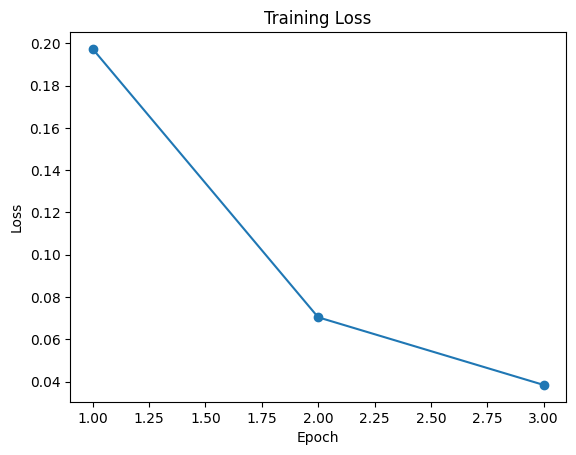

In [13]:

#  Plot Training Loss
plt.plot(range(1,num_epochs+1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()